In [1]:
import numpy as np
import random as rnd
from matplotlib import pyplot as plt
import copy

In [48]:
class Garnet:
    
    """
    
    Value Approximation: theta
    Policy Parameterization: w
    
    diff from professor's notes... troublesome to change it back
    
    """
    
    def __init__(self, Ns, Na, Nb, d_w, gamma):

        self.Ns = Ns # number of states
        self.Na = Na # number of actions in each state
        self.Nb = Nb # branching factor
        self.d_w = d_w   # dimension of feature vector
        self.gamma = gamma # discount factor
        
        self.initGarnet()
    
    # initialize garnet
    def initGarnet(self):
        self.initTransition()
        self.initReward()
        self.initPhi()
        
    def initActorCritic(self,d_theta):
        
        self.d_theta = d_theta
        self.PhiAC = np.random.normal(loc=1,size=(self.Ns,d_theta))
        self.theta = np.zeros((d_theta, 1))
    
    def copy(self):
        return copy.deepcopy(self)
        
        
    #------------------------   
    # initializers
    def initTransition(self):
        # P: s x a x s'
        P = np.zeros((self.Ns, self.Na, self.Ns))
        for i in range(self.Ns):
            for j in range(self.Na):
                sampleArr = rnd.sample(range(self.Ns), k = self.Nb)
                P_sum = np.random.rand(self.Nb - 1)
                P_sum = np.sort([*P_sum, 0, 1])
                for k in range(self.Nb):
                    P[i][j][sampleArr[k]] = P_sum[k + 1] - P_sum[k]
        self.P = P                                            
    
    def initReward(self):
        # R: s x a
        self.R = np.random.uniform(size=(self.Ns, self.Na))
    
    def initPi(self):
        # pi: s x a, uniform random
        self.pi = np.ones((self.Ns, self.Na)) / self.Na    
        
    def initPhi(self, mean=1):
        # linear function approximation on policy function
        # phi: s x a x d, w (weight vector): d x 1
        self.Phi = np.random.normal(loc=mean,size=(self.Ns, self.Na, self.d_w))  
        self.w = np.zeros((self.d_w,1))  
        self.calPolicy()
    
    def genEpisode(self, T):
        
        self.calPolicy()
        
        S = np.ndarray((T+1), int)
        A = np.ndarray((T), int)
        R = np.ndarray((T), float)
        
        S[0] = self.getInitialState()
        
        for t in range(T):
            A[t], R[t], S[t+1] = self.getNext(S[t])
            
        return S, A, R
    
    #------------------------
    # generate sequence
    def getInitialState(self):
        
        self.calValue()
        mu = np.linalg.matrix_power(self.P_pi.T, 100)[:,0]
        mu = mu / mu.sum()
        
        return np.random.choice(np.arange(self.Ns), p=mu)
    
    def getNext(self, s):
        a = self.getAction(s)
        r = self.R[s,a]
        s_next = self.getState(s,a)
        return a, r, s_next
    
    def getNextOTF(self, s):
        
        pi_ = self.Phi[s] @ self.w
        pi_ = pi_ - pi_.max()
        expi = np.exp(pi_) #+ 0.01
        pi = expi / expi.sum()
        
        a = np.random.choice(np.arange(self.Na),p=pi.flatten())
        r = self.R[s,a]
        s_next = self.getState(s,a)
        return a, r, s_next
    
    def getAction(self, s):
            
        return np.random.choice(np.arange(self.Na),p=self.pi[s,:])
    
    def getState(self, s, a):
        return np.random.choice(np.arange(self.Ns), p=self.P[s,a,:])
    
    #------------------------   
    # cal & store true state values given a policy
    def calValue(self):   
        # works for different pi
        P_pi = np.einsum('ijk,ij->ik', self.P, self.pi)  # P_pi: s x s'
        R_pi = np.einsum('ij,ij->i', self.pi, self.R)    # R_pi: s x 1
        self.P_pi = P_pi
        self.R_pi = R_pi
        self.V_pi = np.linalg.inv(np.identity(self.Ns) - self.gamma * P_pi).dot(R_pi)
        return self.V_pi
    
    # calculate the average value given a policy
    def calAvgReward(self):
        
        self.calValue()
        mu = np.linalg.matrix_power(self.P_pi.T, 100)[:,0]
        mu = mu / mu.sum()
        
        return self.R_pi.dot(mu)
    
    def calPolicy(self):
        pi_ = np.einsum('ijk,kl->ij', self.Phi, self.w)
        
        # prevent divide by inf
        for i in range(self.Ns):
            pi_[i] -= pi_[i].max()
        
        pi = np.exp(pi_) / np.exp(pi_).sum(axis=1, keepdims = True)
        
        #expi = np.exp(pi_) + 0.01
        #pi = expi / expi.sum(axis=1, keepdims=True)
        
        self.pi = pi
        
    def calLogPiGradient(self, s, a):
        return (self.Phi[s,a] - np.einsum('ij,i->j',self.Phi[s],self.pi[s])).reshape(self.d_w, -1)
    
    
    def calGradient(self, M=100, T=100):
        
        grad = 0
        
        for m in range(M):
            
            S, A, R = self.genEpisode(T)
            
            G = 0
            for t in reversed(range(T)):
                G = self.gamma * G + R[t]
            
            grad += G * self.calLogPiGradient(S[0],A[0])
        
        return np.abs(grad / M).sum()
    
    #------------------------
    def pgIter(self, T, alpha):
        S, A, R = self.genEpisode(T)
        
        G = 0
        for t in reversed(range(T)):
        
            G = self.gamma * G + R[t]          
            self.w += alpha * (self.gamma ** t) * G * self.calLogPiGradient(S[t], A[t])
            #print("change:",alpha * (self.gamma ** t) * G * self.calLogPiGradient(S[t], A[t]))
        
        self.calPolicy()
    
    def pgBatch(self, T, count,plot=True, grad=False):
        
        AvgRewardList = []
        AvgRewardList.append(self.calAvgReward())
        
        grads = [self.calGradient()] if grad else None
        
        for i in range(count):
            
            alpha = 0.1 / np.sqrt(i + 1)
            self.pgIter(T, alpha)
            AvgRewardList.append(self.calAvgReward())
            
            if grad:
                grads.append(self.calGradient())
            
        if plot:
            plt.plot(range(count+1), AvgRewardList, label="Policy Gradient Algorithm 1")
            plt.title("Average Reward of Policy Gradient Algorithm 1")
            plt.ylabel("Average Reward")
            plt.xlabel("Number of Iterations")
            
        return (np.array([i * T for i in range(count + 1)]), np.array(AvgRewardList), np.array(grads))
        
    #------------------------
    # policy gradient opt (online version)
    def pgOnline(self, alpha, lambd, T, ir,plot=True, grad=False):
        
        # initial setup
        if not hasattr(self, 'G'):
            self.G = np.zeros(self.w.shape)
        if not hasattr(self, 's'):
            self.s = self.getInitialState()
            
        s = self.s
        
        avgRs = [self.calAvgReward()]
        grads = [self.calGradient()] if grad else None
        Ts = [0]
        
        #print("initialG:",self.G)
        
        for t in range(T):
            
            a, r, s_next = self.getNextOTF(s)
            #print("s:{} a:{} r:{} s_next:{}".format(s,a,r,s_next))
            
            self.G = lambd * self.G + self.calLogPiGradient(s, a)
            self.w += alpha / np.sqrt(t + 1) * r * self.G
            
            
            #print("    Change:",(alpha / np.sqrt(t + 10) * r * self.G))
            #print("    G:",self.G)
            #print("    w:",self.w)
            
            # update policy after w has been updated
            #self.calPolicy()
                
            if (t + 1) % (T // ir) == 0:
                self.calPolicy()
                avgRs.append(self.calAvgReward())
                if grad:
                    grads.append(self.calGradient())
                Ts.append(t + 1)
                
            s = s_next
                
        self.s = s
        
        if plot:
            plt.plot(Ts, avgRs, label="Policy Gradient Algorithm 2")
            plt.title("Avg. R of PGOnline")
            plt.xlabel('Length of Sequence')
            plt.ylabel("Average Reward")
            plt.show()
        
        return (np.array(Ts), np.array(avgRs), grads)
    
    #-------------------------
    
    # Actor Critic
    def AdvantageAC(self, alpha, beta, T, ir, plot=True, grad=False):
        
        s = self.getInitialState()
        
        avgRs = [self.calAvgReward()]
        Ts = [0]
        grads = [self.calGradient()] if grad else None
        
        for t in range(T):
        
            a, r, s_next = self.getNextOTF(s)
            
            delta = r + self.gamma * self.PhiAC[s_next].dot(self.theta) \
                - self.PhiAC[s].dot(self.theta)
            
            # Actor (w)
            self.w += alpha / (t + 1) * delta * self.calLogPiGradient(s,a)
            
            # Critic (theta)
            self.theta += beta / ((t + 1)** (2/3)) * delta * self.PhiAC[s].reshape(self.d_theta,1)
            
            #self.calPolicy()  # use getNextOTF
            
            s = s_next
            
            if (t + 1) % (T // ir) == 0:
                self.calPolicy()
                avgRs.append(self.calAvgReward())
                if grad:
                    grads.append(self.calGradient())
                Ts.append(t + 1)
        
        if plot:
            plt.plot(Ts, avgRs, label="Advantage Actor Critic")
            plt.title("Avg. R of AAC")
            plt.xlabel('Length of Sequence')
            plt.ylabel("Average Reward")
            plt.show()
        
        return (np.array(Ts), np.array(avgRs), grads)

In [73]:
g1 = Garnet(10, 3, 2, 5, 0.9)
g2 = g1.copy()
g3 = g1.copy()
g3.initActorCritic(8)

In [68]:
(np.exp((g1.Phi[0] @ g1.w)) / np.exp((g1.Phi[0] @ g1.w)).sum()).flatten()

array([0.33333333, 0.33333333, 0.33333333])

In [75]:
g3.calValue()

array([5.61073593, 5.86152351, 5.55908033, 5.33444337, 5.62566954,
       5.19453286, 5.18491202, 5.19296522, 5.49080376, 5.07177247])

In [76]:
g3.PhiAC @ g3.theta

array([[5.30260875],
       [5.38610212],
       [5.33556233],
       [5.0383379 ],
       [6.57648931],
       [3.26307221],
       [4.82331413],
       [0.81697733],
       [5.19849496],
       [5.61530354]])

In [50]:
# Algorithm 1 testing
x1, y1, grad1 = g1.pgBatch(50, 600, plot=False)#,grad=True)

In [51]:
# Algorithm 2 testing
x2, y2, grad2 = g2.pgOnline(3e-3, 1-1e-4, 30000, 300, plot=False)#, grad=True)

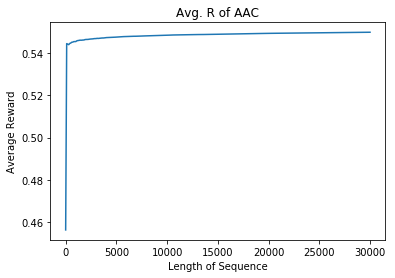

In [74]:
x3, y3, grad3 = g3.AdvantageAC(0.6, 0.6, 30000, 300)#, plot=False)#, grad=True)

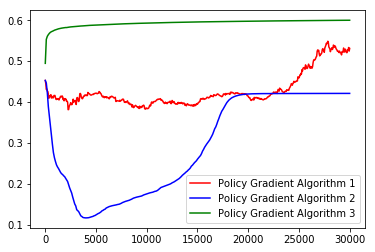

In [62]:
plt.plot(x1, y1, 'r',label="Policy Gradient Algorithm 1")
plt.plot(x2, y2, 'b', label="Policy Gradient Algorithm 2")
plt.plot(x3, y3, 'g', label="Policy Gradient Algorithm 3")
plt.legend()
plt.show()

In [233]:
print(g1.calGradient())
print(g2.calGradient())

1.2046710960517397
1.8451716407448409


In [ ]:
"""plt.plot(x1, grad1, 'r',label="Policy Gradient Algorithm 1")
plt.plot(x2, grad2, 'b', label="Policy Gradient Algorithm 2")
plt.legend()
plt.show()

In [79]:
def ExpectedPerformance(N:int, T: int, Tin: int):
    
    
    reward1 = np.zeros(T // Tin + 1)
    reward2 = np.zeros(T // Tin + 1)
    reward3 = np.zeros(T // Tin + 1)
    
    #grad1 = np.zeros(T // Tin + 1)
    #grad2 = np.zeros(T // Tin + 1)
    
    for n in range(N):
        
        print("N: ",n + 1)
        
        g1 = Garnet(10, 3, 2, 5, 0.9)
        g2 = g1.copy()
        g3 = g1.copy()
        g3.initActorCritic(8)
        
        _, r1, _ = g1.pgBatch(Tin, T // Tin, plot=False)#, grad=True)
        _, r2, _ = g2.pgOnline(3e-3, 1-1e-4, T, T // Tin, plot=False)#, grad=True)
        _, r3, _ = g3.AdvantageAC(0.2, 0.4, T, T // Tin, plot=False)#, grad=True)
        
        reward1 = reward1 + r1
        reward2 = reward2 + r2
        reward3 += r3
        
        #print(g1.calGradient())
        #print(g2.calGradient())
        
        #grad1 = grad1 + g1
        #grad2 = grad2 + g2
        
            
    
    Ts = range(0, T + 1, Tin)
    
    plt.plot(Ts, reward1 / N, "r",label="REINFORCE")
    plt.plot(Ts, reward2 / N, "b", label="PG Online")
    plt.plot(Ts, reward3 / N, "g", label="Advantage AC")
    plt.xlabel("Length of Sequence")
    plt.ylabel("Average Reward (Over {} trials)".format(N))
    plt.legend()
    plt.show()
    
    """plt.plot(Ts, grad1 / N, "r",label="REINFORCE")
    plt.plot(Ts, grad2 / N, "b", label="PG Online")
    plt.xlabel("Length of Sequence")
    plt.ylabel("Gradient (Over {} trials)".format(N))
    plt.legend()
    plt.show()"""
    

N:  1
0.6433544402028255
0.7602737045456548
N:  2
0.40626187830308497
0.8004501743542664
N:  3
0.575553370707387
0.9986301376126083
N:  4
0.24644702694338125
0.5710035846949008
N:  5
0.6967579368219502
0.10009188342985054
N:  6
0.60987670136652
0.32600709302119435
N:  7
0.5541625976484613
1.4145688995367505
N:  8
0.5787585143072228
0.7579963118442867
N:  9
1.7844674763944628
0.2535134148518675
N:  10
0.3728453370562414
0.8710023556346754


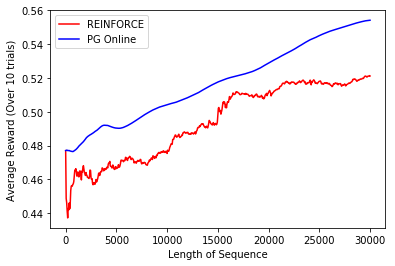

In [10]:
ExpectedPerformance(10,30000,50) #3e-4, 1-1e-5

N:  1
0.396329901951543
0.20170134432110925
N:  2
0.4156981915001034
0.21710164402810525
N:  3
0.7238195243046722
0.09720898462123391
N:  4
0.644074510486367
0.8305803891488504
N:  5
0.204609585926528
1.4736574568416303
N:  6
0.16011252739054488
0.15693508732080835
N:  7
0.9851079630647798
0.16446353687674742
N:  8
0.34702182968697964
0.22489971659748503
N:  9
0.43226669257977607
0.3725481863315583
N:  10
0.1802100378681722
1.2461398174406482


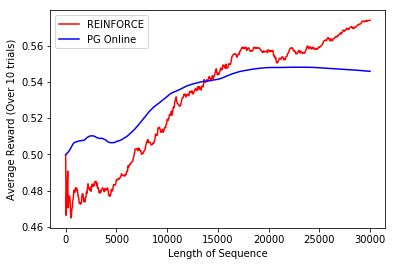

In [11]:
ExpectedPerformance(10,30000,50) #3e-4, 1-1e-5

N:  1
N:  2
N:  3
N:  4
N:  5
N:  6
N:  7
N:  8
N:  9
N:  10


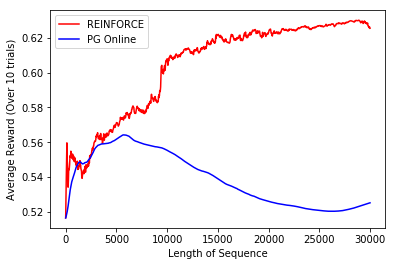

In [22]:
ExpectedPerformance(10,30000,30) #1e-3, 1-1e-5

N:  1
N:  2
N:  3
N:  4
N:  5
N:  6
N:  7
N:  8
N:  9
N:  10


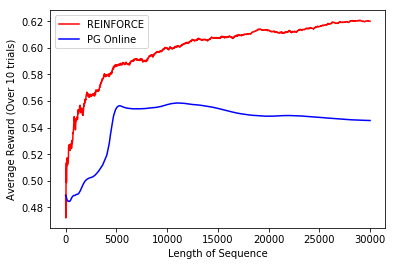

In [23]:
ExpectedPerformance(10,30000,10) #1e-3, 1-1e-5

N:  1
N:  2
N:  3
N:  4
N:  5
N:  6
N:  7
N:  8
N:  9
N:  10


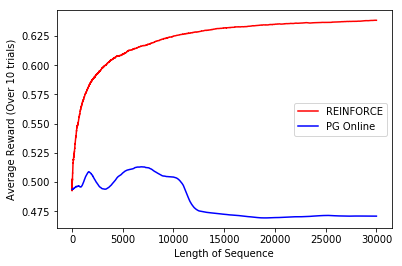

In [24]:
ExpectedPerformance(10,30000,1) #1e-3, 1-1e-5

N:  1
N:  2
N:  3
N:  4
N:  5
N:  6
N:  7
N:  8
N:  9
N:  10


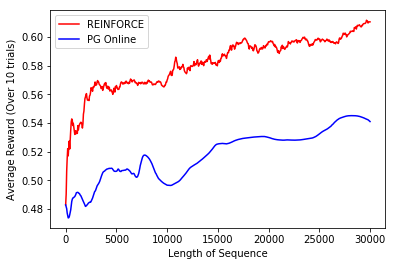

In [196]:
ExpectedPerformance(10,30000,50) #3e-3, 1-1e-4

N:  1
N:  2
N:  3
N:  4
N:  5
N:  6
N:  7
N:  8
N:  9
N:  10


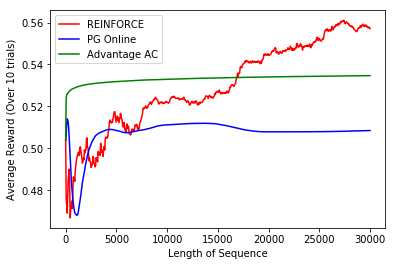

In [80]:
ExpectedPerformance(10,30000,50) #3e-3, 1-1e-4